In [21]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import torch
from torch import nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset,Dataset
import os
import copy

In [22]:
data = np.load('../../CESM_data/ResNet50_data/CESM_data_sst_sss_psl_deseason_normalized_resized.npy')
target = np.load('../../CESM_data/ResNet50_data/CESM_label_amv_index.npy')

In [24]:
tstep = 86
percent_train = 0.8
ens = 1
channels = 3
batch_size = 32
max_epochs = 10

In [4]:
data = data[:,0:ens,:,:,:]
data.shape

(3, 40, 86, 244, 244)

In [5]:
target = target[0:ens,:]
target.shape

(40, 86)

In [6]:
lead = 10

y = target[:,lead:].reshape(ens*(tstep-lead),1)
X = (data[:,:,:tstep-lead,:,:]).reshape(3,ens*(tstep-lead),244,244).transpose(1,0,2,3)

In [7]:
X_train = torch.from_numpy( X[0:int(np.floor(percent_train*(tstep-lead)*ens)),:,:,:].astype(np.float32) )

X_val = torch.from_numpy( X[int(np.floor(percent_train*(tstep-lead)*ens)):,:,:,:].astype(np.float32) )

y_train = torch.from_numpy(  y[0:int(np.floor(percent_train*(tstep-lead)*ens)),:].astype(np.float32)  )

y_val = torch.from_numpy( y[int(np.floor(percent_train*(tstep-lead)*ens)):,:].astype(np.float32)  )

In [8]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

In [9]:
model = models.resnet50(pretrained=True)

In [10]:
for param in model.parameters():
    param.requires_grad = False

In [11]:
model.fc = nn.Linear(2048, 1)

In [12]:
opt = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

In [14]:
epo_train_losses = [] #[loss_fn(model(X_train),y_train)]
epo_val_losses = [] #[loss_fn(model(X_val),y_val)]


for iepoch in tqdm(range(max_epochs)):
    
    batch_train_losses = []
    model.train()
    for x_batch, y_batch in train_loader:
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        batch_train_losses.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
    epo_train_losses.append( sum(batch_train_losses)/len(batch_train_losses) )

    batch_val_losses = []
    with torch.set_grad_enabled(False):
        for x_batch_val, y_batch_val in val_loader:
            y_pred = model(x_batch_val)
            loss = loss_fn(y_pred, y_batch_val)
            batch_val_losses.append(loss.item())
        epo_val_losses.append( sum(batch_val_losses)/len(batch_val_losses) )

100%|██████████| 10/10 [1:55:08<00:00, 690.84s/it]


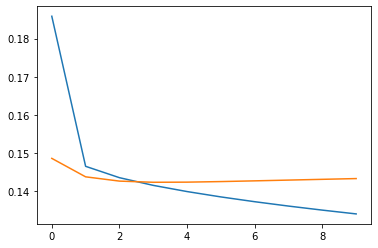

In [15]:
plt.plot(epo_train_losses)
plt.plot(epo_val_losses)

In [16]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
y_pred_val = model(X_val)
y_pred_train = model(X_train)

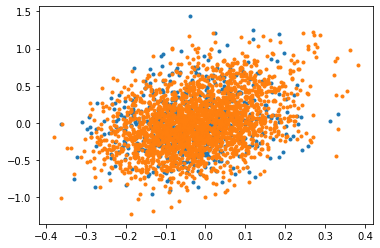

In [18]:
plt.plot(y_pred_val.detach().numpy()[:,0],y_val.detach().numpy()[:,0],'.' )
plt.plot(y_pred_train.detach().numpy()[:,0],y_train.detach().numpy()[:,0],'.' )

In [19]:
np.corrcoef( y_pred_val.detach().numpy()[:,0],y_val.detach().numpy()[:,0] )

array([[1.        , 0.19024256],
       [0.19024256, 1.        ]])

In [20]:
np.corrcoef( y_pred_train.detach().numpy()[:,0],y_train.detach().numpy()[:,0] )

array([[1.        , 0.36289822],
       [0.36289822, 1.        ]])